# 双目(立体)视觉
## 基本概念
1. 极线  
一张图中一个一个点,投影在另一张图上,这个点在另一张图上的位置是不确定的,但是这个点在另一张图上的位置一定在一条直线上.
2. 极线约束  
为了找一个点在另一张图上的位置,只需要在另一张图上的一条直线上找就可以了.
3. 极平面  
是一个平面,这个平面包含了两个相机的光心和物体点
4. 极点  
是一个点,这个点是两个相机光心的连线与极平面的交点
## 基本模型:    
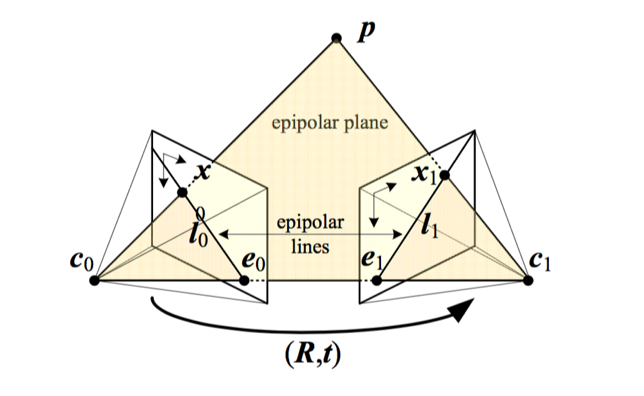
1. c0、c1为两个相机中心，p为空间中一点，
2. p在c0、c1对应像平面上的投影分别为x0、x1。
3. c0、c1连线与像平面的交点e0、e1称为极点（Epipoles），
4. l0、l1称为极线（Epipolar Lines），
5. c0、c1、p三点组成的平面称为极平面（Epipolar Plane）。

## 寻找极线和极点
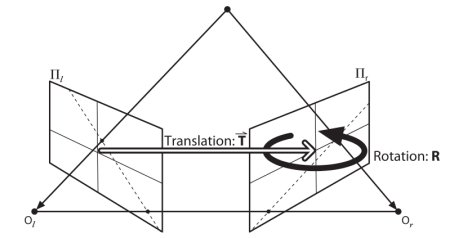  

**本征矩阵**包括平移和旋转的信息，用以描述第二个摄像机在全局坐标中相对于第一个摄像机的位置.  
**基础矩阵** ，会将图像上的一个点映射为另一个图像的一条线(极线)。  
**注意**: 如果我们使用校正后的图像，并用焦距除以该点标准化，则$$F=E$$

In [14]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - 为了在 img2 为点绘制极线的图像
        lines - 对应的极线 '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2



img1 = cv.imread('../data/left.jpg',0) #训练图像 # 右图像
img2 = cv.imread('../data/right.jpg',0)  #查询图像 # 左图像

#sift = cv.SIFT()
sift = cv.SIFT_create()

kp1,des1= sift.detectAndCompute(img1, None)
kp2,des2= sift.detectAndCompute(img2, None)
# 使用 SIFT 获得特征点和描述符
# kp1, des1 = sift.detectAndCompute(img1,None)
# kp2, des2 = sift.detectAndCompute(img2,None)
#debug


# FLANN 参数
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

# 根据 Lowe's 的论文进行比率测试
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
#debug
print(pts1.shape)
print(pts2.shape)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)

# 我们只会选取内部点
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

# 寻找到极线在右图像(第二图像)对应的点并
# 在左图像绘制连线
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# 寻找到极线在左图像(第一图像)对应的点并
# 在右图像绘制连线
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

img_total = np.concatenate((img5, img3), axis=1)

cv.imshow("img_total", img_total)
cv.waitKey(0)
cv.destroyAllWindows()



(158, 2)
(158, 2)
